# create_counterfactual: Interpreting models via counterfactuals

An implementation of the counterfactual method by Wachter et al. 2017 for model interpretability.

> `from mlxtend.evaluate import create_counterfactual`    

## Overview

Counterfactuals are instances that explain scenarios related to implication: "if not x, then not y" in a hypothetical context. For example, "if I hadn't studied hard, my grade would be worse." 

In the context of machine learning, we can think of counterfactual instances from the training set for which we artificially change its features to change the model prediction. Changing features of a training example can be useful to interpret the behavior of the model.

Note that this implementation for creating counterfactuals is model agnostic and works with any scikit-learn estimators that support the `predict` (and ideally `predict_proba`) method.


In particular, the `create_counterfactual` implements the method described by Wachter et al. 2017 [1]. A good, short description of this method is also available in C. Molnar's Interpretable Machine Learning Book [2].



In short, Wachter et al.'s method minimizes the loss

$$L\left(x, x^{\prime}, y^{\prime}, \lambda\right)=\lambda \cdot\left(\hat{f}\left(x^{\prime}\right)-y^{\prime}\right)^{2}+d\left(x, x^{\prime}\right).$$

The left term, $\lambda \cdot\left(\hat{f}\left(x^{\prime}\right)-y^{\prime}\right)^{2}$, minimizes the squared difference between the model prediction for the counterfactual $x'$, i.e., $\hat{f}\left(x^{\prime}\right)$, and the desired prediction (specified by the user), $y^{\prime}$. Note that $\lambda$ is a hyperparameter for weighting the importance of this left term over the second term, $d\left(x, x^{\prime}\right)$.

The second term, $d\left(x, x^{\prime}\right)$, calculates the distance between a given instance $x$ and a generated counterfactual $x'$. In short, the second term will keep the generated counterfactual similar to the instance. In contrast, the first term maximizes the difference between the model prediction for the counterfactual and the desired prediction (for example, a different class label).

The distance function is implemented as the absolute difference in each feature dimension scaled by the median absolute deviation (MAD):

$$d\left(x, x^{\prime}\right)=\sum_{j=1}^{p} \frac{\left|x_{j}-x_{j}^{\prime}\right|}{M A D_{j}}.$$

The MAD measures the spread of a given feature, using the median as its center:

$$MAD_{j}=\operatorname{median}_{i \in\{1, \ldots, n\}}\left(\left|x_{i, j}-\operatorname{median}_{l \in\{1, \ldots, n\}}\left(x_{l, j}\right)\right|\right).$$

The general procedure for using the `create_counterfactual` function is as follows.

1. Select an instance that you want to explain and specify the desired prediction $y'$ for this instance (this is usually different from its original prediction).
2. Choose a value for the hyperparameter $\lambda$
3. Optimize the loss $L$ using the `create_counterfactual` function
4. Optionally, as the authors recommend, you can repeat steps 2 and 3 by increasing $\lambda$ until a user-defined threshold $\epsilon$ is reached, i.e.,
    - while $\left|\hat{f}\left(x^{\prime}\right)-y^{\prime}\right|>\epsilon$:
        - increase $\lambda$

### References

- [1] Wachter, S., Mittelstadt, B., & Russell, C. (2017). Counterfactual explanations without opening the black box: Automated decisions and the GDPR. Harv. JL & Tech., 31, 841., [https://arxiv.org/abs/1711.00399](https://arxiv.org/abs/1711.00399)
- [2] Christoph Molnar (2018). Interpretable Machine Learning, [Chapter 6.1](https://christophm.github.io/interpretable-ml-book/counterfactual.html)

## Example 1 -- Simple Iris Example

For simplicity, this example illustrates how to use the `create_counterfactual` function to explain a data instance from the iris dataset.

Suppose we trained a logistic regression model on the iris dataset and pick the 16th training point for which we want to explain the prediction via counterfactuals.

In [1]:
from mlxtend.data import iris_data
from sklearn.linear_model import LogisticRegression


X, y = iris_data()
clf = LogisticRegression()
clf.fit(X, y)

x_ref = X[15]

print('True label:', y[15])
print('Predicted label:', clf.predict(x_ref.reshape(1, -1))[0])
print('Predicted probas:', clf.predict_proba(x_ref.reshape(1, -1)))
print('Predicted probability for label 0:', clf.predict_proba(x_ref.reshape(1, -1))[0][0])

True label: 0
Predicted label: 0
Predicted probas: [[9.86677291e-01 1.33226960e-02 1.28980184e-08]]
Predicted probability for label 0: 0.9866772910539873


We can see above, that there is a predicted score of 98.6% probability for a class 0 membership. Now, we are going to push the prediction towards class 2 by setting `y_desired=2`. Moreover, we set the probability for class 2 to 100% via`y_desired_proba=1.`


In [2]:
from mlxtend.evaluate import create_counterfactual


res = create_counterfactual(x_reference=x_ref, 
                            y_desired=2, 
                            model=clf, 
                            X_dataset=X,
                            y_desired_proba=1.,
                            lammbda=1, #  hyperparameter
                            random_seed=123)

print('Features of the 16th training example:', x_ref)
print('Features of the countefactual:', res)

print('Predictions for counterfactual:\n')
print('Predicted label:', clf.predict(res.reshape(1, -1))[0])
print('Predicted probas:', clf.predict_proba(res.reshape(1, -1)))

Features of the 16th training example: [5.7 4.4 1.5 0.4]
Features of the countefactual: [5.72271344 3.99169005 6.45305374 0.40000002]
Predictions for counterfactual:

Predicted label: 2
Predicted probas: [[1.41639932e-04 3.13292297e-01 6.86566063e-01]]


As we can see above, the counterfactual is relatively similar to the original training example, i.e, only the 3rd feature has changed substantially (from 1.5 to 6.45). The predicted label has changed from class 0 t class 2. 

Interpretation-wise, this means increasing the petal length of a Iris-setosa flower may make it more similar to a Iris-virginica flower.

## Example 2 -- Simple Iris Example with Decision Regions and Threshold Stopping Criterion

This example is similar to Example 1; however, it is based on a 2D iris dataset containing only petal length and petal width features so that the results can be plotted via a decision region plot.

In [3]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt


X, y = iris_data()
X = X[:, 2:]
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

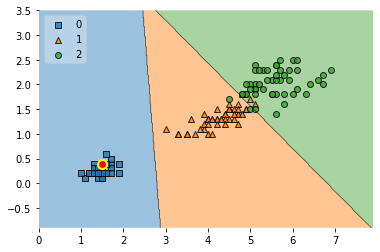

In [4]:
# Plotting decision regions
ax = plot_decision_regions(X, y, clf=clf, legend=2)


scatter_highlight_defaults = {'c': 'red',
                              'edgecolor': 'yellow',
                              'alpha': 1.0,
                              'linewidths': 2,
                              'marker': 'o',
                              's': 80}

ax.scatter(*X[15],
           **scatter_highlight_defaults)
plt.show()

The big, highlighted point in the plot above shows the 16th training datapoint. 

The following code will create a counterfactual with the same settings as in Example 1:

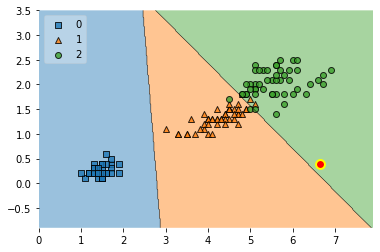

In [5]:
counterfact = create_counterfactual(x_reference=X[15], 
                                    y_desired=2, 
                                    model=clf, 
                                    X_dataset=X,
                                    y_desired_proba=1.0,
                                    lammbda=1, 
                                    random_seed=123)


ax = plot_decision_regions(X, y, clf=clf, legend=2)
ax.scatter(*counterfact,
           **scatter_highlight_defaults)
plt.show()

As we can see above, the counterfactual primarily moved along the x-axis (petal length) so that the prediction between the rerence point and the counterfactual changes from class 0 to class 2.

The following plots are based on repeating this procedure with different lambda values:

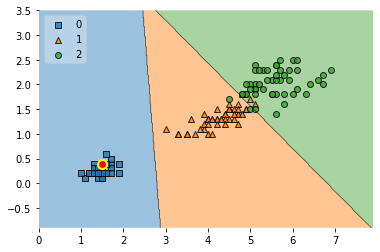

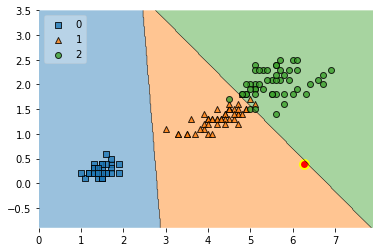

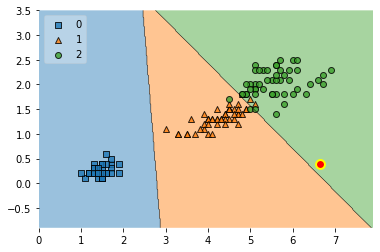

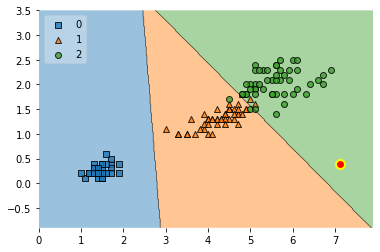

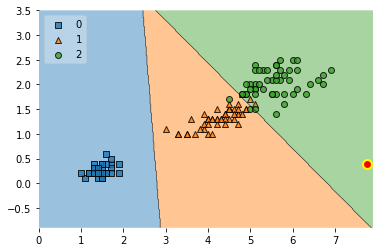

In [6]:
for i in [0.4, 0.5, 1.0, 5.0, 100]:

    counterfact = create_counterfactual(x_reference=X[15], 
                                        y_desired=2, 
                                        model=clf, 
                                        X_dataset=X,
                                        y_desired_proba=1.0,
                                        lammbda=i, 
                                        random_seed=123)


    ax = plot_decision_regions(X, y, clf=clf, legend=2)
    ax.scatter(*counterfact,
               **scatter_highlight_defaults)

    plt.show()

As we can see, the stronger the $\lambda$ value, the more the first term in the loss

$$L\left(x, x^{\prime}, y^{\prime}, \lambda\right)=\lambda \cdot\left(\hat{f}\left(x^{\prime}\right)-y^{\prime}\right)^{2}+d\left(x, x^{\prime}\right).$$

dominates.

Applying Wachter et al.'s threshold concept,

>4. Optionally, as the authors recommend, you can repeat steps 2 and 3 by increasing $\lambda$ until a user-defined threshold $\epsilon$ is reached, i.e.,
    - while $\left|\hat{f}\left(x^{\prime}\right)-y^{\prime}\right|>\epsilon$:
        - increase $\lambda$
        
we can define a user-defined threshold and implement it as follows:

Initial lambda: 0.0
Initial diff: 0.9999998976132334
Final lambda: 1.1
Final diff: 0.2962621523225484


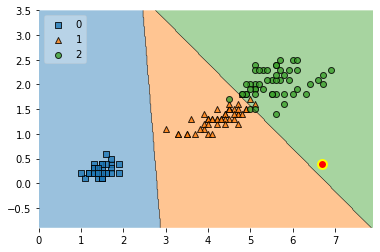

In [7]:
import numpy as np


desired_class_2_proba = 1.0

for i in np.arange(0, 10000, 0.1):

    counterfact = create_counterfactual(x_reference=X[15], 
                                        y_desired=2, 
                                        model=clf, 
                                        X_dataset=X,
                                        y_desired_proba=desired_class_2_proba,
                                        lammbda=i, 
                                        random_seed=123)

    predicted_class_2_proba = clf.predict_proba(counterfact.reshape(1, -1))[0][2]

    if not i:
        print('Initial lambda:', i)
        print('Initial diff:', np.abs(predicted_class_2_proba - desired_class_2_proba))
    
    
    if not np.abs(predicted_class_2_proba - desired_class_2_proba) > 0.3:
        break
    
    
ax = plot_decision_regions(X, y, clf=clf, legend=2)
ax.scatter(*counterfact,
           **scatter_highlight_defaults)

print('Final lambda:', i)
print('Final diff:', np.abs(predicted_class_2_proba - desired_class_2_proba))


plt.show()

## API

In [8]:
with open('../../api_modules/mlxtend.evaluate/create_counterfactual.md', 'r') as f:
    s = f.read() 
print(s)

## create_counterfactual

*create_counterfactual(x_reference, y_desired, model, X_dataset, y_desired_proba=None, lammbda=0.1, random_seed=None)*

Implementation of the counterfactual method by Wachter et al.

References:

- Wachter, S., Mittelstadt, B., & Russell, C. (2017).
Counterfactual explanations without opening the black box:
Automated decisions and the GDPR. Harv. JL & Tech., 31, 841.,
https://arxiv.org/abs/1711.00399

**Parameters**


- `x_reference` : array-like, shape=[m_features]

    The data instance (training example) to be explained.


- `y_desired` : int

    The desired class label for `x_reference`.


- `model` : estimator

    A (scikit-learn) estimator implementing `.predict()` and/or
    `predict_proba()`.
    - If `model` supports `predict_proba()`, then this is used by
    default for the first loss term,
    `(lambda * model.predict[_proba](x_counterfact) - y_desired[_proba])^2`
    - Otherwise, method will fall back to `predict`.


- `X_dataset` : array-like, 